In [1]:
import pandas as pd
import numpy as np
from obspy.clients.fdsn import Client
from pnwstore.mseed import WaveformClient
from datetime import datetime
import obspy
from matplotlib import pyplot as plt
from obspy import UTCDateTime

from obspy.geodetics import locations2degrees, degrees2kilometers
from tqdm import tqdm

## Morton Catalog

In [2]:
# Read Morton's catalog
events_morton = pd.read_csv('../data/ds01.csv')
# Convert the TSTRING to datetime
events_morton['datetime'] = pd.to_datetime(events_morton['TSTRING'], format='%Y%m%d%H%M%S', utc=True)
# Get the events in the Morton catalog that occurred on 10/14/2012
t1 = pd.Timestamp('2012-10-01 00:00:00.000000+0000', tz='UTC')
t2 = pd.Timestamp('2012-10-31 23:59:59.999999+0000', tz='UTC')

events_morton_201210= events_morton.loc[(events_morton['datetime'] > t1) & (events_morton['datetime'] < t2) ]

events_morton_201210.head()

,CI YEAR,TSTRING,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,LAT,LON,...,dist to nearest stn,tt RMS,ERH,ERZ,STRIKE,DIP,RAKE,PLATE DESIGNATION,TEMPLATE EVENT?,datetime
630,2.0,2.012100e+13,2012.0,10.0,1.0,4.0,32.0,57.05,40.7190,-125.9525,...,34.0,0.46,2.6,29.2,NaN,NaN,NaN,Seaward of Trench,NaN,2012-10-01 04:32:57+00:00
631,2.0,2.012100e+13,2012.0,10.0,1.0,23.0,30.0,58.38,40.5787,-124.8887,...,11.8,0.34,6.9,5.8,NaN,NaN,NaN,Slab,NaN,2012-10-01 23:30:58+00:00
632,2.0,2.012100e+13,2012.0,10.0,2.0,4.0,25.0,46.37,40.5592,-125.2087,...,24.1,0.30,1.7,5.0,NaN,NaN,NaN,Seaward of Trench,NaN,2012-10-02 04:25:46+00:00
633,2.0,2.012100e+13,2012.0,10.0,2.0,5.0,16.0,28.35,40.5075,-124.5450,...,7.3,0.35,1.1,1.2,NaN,NaN,NaN,Slab,NaN,2012-10-02 05:16:28+00:00
634,2.0,2.012100e+13,2012.0,10.0,2.0,6.0,17.0,18.88,40.4213,-125.3963,...,31.2,0.46,1.4,34.8,316.59,43.54,-85.95,Seaward of Trench,NaN,2012-10-02 06:17:18+00:00


In [3]:
events_morton['datetime'].max()

Timestamp('2015-10-07 21:45:50+0000', tz='UTC')

In [4]:
events_morton_201210.keys()

Index(['CI YEAR', 'TSTRING', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE',
       'SECOND', 'LAT', 'LON', 'DEPTH', 'Md', 'Num P&S with weights > 0.1',
       'max az gap', 'dist to nearest stn', 'tt RMS', 'ERH', 'ERZ', 'STRIKE',
       'DIP', 'RAKE', 'PLATE DESIGNATION', 'TEMPLATE EVENT?', 'datetime'],
      dtype='object')

In [5]:
len(events_morton_201210)

91

## Our Catalog

In [6]:
# Load all the pick assignments 
mycatalog = pd.read_csv('../data/all_pick_assignments_october_temp_with_JCC.csv')
# Convert the time series in all_pick_assignments to datetime
mycatalog['datetime'] = pd.to_datetime(mycatalog['time'], utc = True)
mycatalog=mycatalog.loc[(mycatalog['datetime'] > t1) & (mycatalog['datetime'] < t2) ]
mycatalog.head()

,Unnamed: 0,idx,time,x,y,z,picks,latitude,longitude,depth,event_idx,pick_idx,residual,station,phase,time_pick,datetime
0,0,0,2012-10-01 04:32:57.526930+00:00,-95.153374,-109.358894,38.671875,9,40.759805,-125.876866,38.671875,0,191641,0.691466,FS20B,S,1.349066e+09,2012-10-01 04:32:57.526930+00:00
1,1,0,2012-10-01 04:32:57.526930+00:00,-95.153374,-109.358894,38.671875,9,40.759805,-125.876866,38.671875,0,52682,-0.194832,G10B,P,1.349066e+09,2012-10-01 04:32:57.526930+00:00
2,2,0,2012-10-01 04:32:57.526930+00:00,-95.153374,-109.358894,38.671875,9,40.759805,-125.876866,38.671875,0,195745,-0.455126,G10B,S,1.349066e+09,2012-10-01 04:32:57.526930+00:00
3,3,0,2012-10-01 04:32:57.526930+00:00,-95.153374,-109.358894,38.671875,9,40.759805,-125.876866,38.671875,0,72030,0.389036,G19B,P,1.349066e+09,2012-10-01 04:32:57.526930+00:00
4,4,0,2012-10-01 04:32:57.526930+00:00,-95.153374,-109.358894,38.671875,9,40.759805,-125.876866,38.671875,0,214198,0.052522,G19B,S,1.349066e+09,2012-10-01 04:32:57.526930+00:00


In [7]:
mycatalog

,Unnamed: 0,idx,time,x,y,z,picks,latitude,longitude,depth,event_idx,pick_idx,residual,station,phase,time_pick,datetime
0,0,0,2012-10-01 04:32:57.526930+00:00,-95.153374,-109.358894,38.671875,9,40.759805,-125.876866,38.671875,0,191641,0.691466,FS20B,S,1.349066e+09,2012-10-01 04:32:57.526930+00:00
1,1,0,2012-10-01 04:32:57.526930+00:00,-95.153374,-109.358894,38.671875,9,40.759805,-125.876866,38.671875,0,52682,-0.194832,G10B,P,1.349066e+09,2012-10-01 04:32:57.526930+00:00
2,2,0,2012-10-01 04:32:57.526930+00:00,-95.153374,-109.358894,38.671875,9,40.759805,-125.876866,38.671875,0,195745,-0.455126,G10B,S,1.349066e+09,2012-10-01 04:32:57.526930+00:00
3,3,0,2012-10-01 04:32:57.526930+00:00,-95.153374,-109.358894,38.671875,9,40.759805,-125.876866,38.671875,0,72030,0.389036,G19B,P,1.349066e+09,2012-10-01 04:32:57.526930+00:00
4,4,0,2012-10-01 04:32:57.526930+00:00,-95.153374,-109.358894,38.671875,9,40.759805,-125.876866,38.671875,0,214198,0.052522,G19B,S,1.349066e+09,2012-10-01 04:32:57.526930+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5079,5079,413,2012-10-31 23:52:18.863116+00:00,-30.939441,-123.840003,25.390625,6,40.634324,-125.115721,25.390625,413,161602,-0.016219,FS09B,S,1.351728e+09,2012-10-31 23:52:18.863116+00:00
5080,5080,413,2012-10-31 23:52:18.863116+00:00,-30.939441,-123.840003,25.390625,6,40.634324,-125.115721,25.390625,413,19435,0.097867,FS13B,P,1.351728e+09,2012-10-31 23:52:18.863116+00:00
5081,5081,413,2012-10-31 23:52:18.863116+00:00,-30.939441,-123.840003,25.390625,6,40.634324,-125.115721,25.390625,413,170646,-0.376346,FS13B,S,1.351728e+09,2012-10-31 23:52:18.863116+00:00
5082,5082,413,2012-10-31 23:52:18.863116+00:00,-30.939441,-123.840003,25.390625,6,40.634324,-125.115721,25.390625,413,32021,-0.435223,FS16B,P,1.351728e+09,2012-10-31 23:52:18.863116+00:00


In [13]:
matched_events_mycatalog= []
matched_times_morton = []
# matched_time_mycatalog = []
# matched_time_morton = []
unmatched_times_morton = []
unmatched_events_mycatalog = []
time_threshold = 5

lat_morton=[]
lon_morton=[]

for i in range(len(events_morton_201210)):
    t1 = events_morton_201210.iloc[i]['datetime']
    matched_df = mycatalog.loc[(mycatalog['datetime'] >= t1 - pd.Timedelta(time_threshold,'seconds')) & 
                               (mycatalog['datetime'] <= t1 +pd.Timedelta(time_threshold,'seconds')) ]
    
    unmatched_df = mycatalog.loc[~((mycatalog['datetime'] > t1 - pd.Timedelta(time_threshold,'minutes')) & 
                               (mycatalog['datetime'] < t1 +pd.Timedelta(time_threshold,'minutes'))) ]
    
    # If there is only one match, append the time with the closest match. 
    unmatched_events_mycatalog.append(unmatched_df)

    # Instead of appending individual rows, append DataFrames directly
    if len(matched_df) == 1:
        matched_times_morton.append(t1)
        lat_morton.append(events_morton_201210.iloc[i]['LAT'])
        lon_morton.append(events_morton_201210.iloc[i]['LON'])
        matched_events_mycatalog.append(matched_df) # Append DataFrame directly

    elif len(matched_df) > 1:
        diffs = abs(matched_df['datetime']-t1)
        matched_times_morton.append(t1)
        lat_morton.append(events_morton_201210.iloc[i]['LAT'])
        lon_morton.append(events_morton_201210.iloc[i]['LON'])
        matched_df = matched_df.iloc[[np.argmin(diffs)]] # Wrap np.argmin(diffs) with list to ensure it returns a DataFrame
        matched_events_mycatalog.append(matched_df) # Append DataFrame directly
    
    
    else: 
        unmatched_times_morton.append(t1)
        

    
    print(i,len(matched_events_mycatalog),len(matched_df), len(matched_df['time'].unique()), events_morton_201210.iloc[i]['Md'])

# unmatched_df = np.setdiff1d(np.array(mycatalog['datetime']), np.array(matched_events_mycatalog['datetime']))
# len(matched_events_mycatalog)

0 1 1 1 3.68
1 2 1 1 2.37
2 3 1 1 2.94
3 4 1 1 2.8
4 5 1 1 3.02
5 6 1 1 3.03
6 7 1 1 1.67
7 8 1 1 3.26
8 8 0 0 1.16
9 9 1 1 2.78
10 10 1 1 3.2
11 10 0 0 2.26
12 10 0 0 1.77
13 10 0 0 2.55
14 10 0 0 1.72
15 11 1 1 2.19
16 12 1 1 2.26
17 13 1 1 3.21
18 14 1 1 2.78
19 15 1 1 2.75
20 16 1 1 3.13
21 17 1 1 2.83
22 18 1 1 2.71
23 19 1 1 2.44
24 20 1 1 2.65
25 21 1 1 2.43
26 22 1 1 3.14
27 23 1 1 2.95
28 24 1 1 3.04
29 25 1 1 2.5
30 26 1 1 3.0
31 26 0 0 1.61
32 26 0 0 1.9
33 27 1 1 2.5
34 27 0 0 2.45
35 28 1 1 2.51
36 29 1 1 2.97
37 30 1 1 2.6
38 31 1 1 2.59
39 32 1 1 2.55
40 33 1 1 2.65
41 34 1 1 2.43
42 35 1 1 2.78
43 35 0 0 1.94
44 36 1 1 2.57
45 37 1 1 2.74
46 38 1 1 2.57
47 38 0 0 2.09
48 39 1 1 2.76
49 40 1 1 3.33
50 40 0 0 1.5
51 41 1 1 2.44
52 42 1 1 2.91
53 43 1 1 2.35
54 44 1 1 2.91
55 45 1 1 2.45
56 46 1 1 2.9
57 47 1 1 2.96
58 48 1 1 4.26
59 49 1 1 4.06
60 50 1 1 2.55
61 51 1 1 2.99
62 52 1 1 2.81
63 53 1 1 2.8
64 54 1 1 3.81
65 55 1 1 2.64
66 56 1 1 3.01
67 56 0 0 2.08
68 57 1 1 

In [33]:
# For debugging 
print(len(matched_times_morton),len(events_morton_201210),len(unmatched_times_morton),)
pd

78 91 13


<module 'pandas' from '/home/jupyter_share/miniconda3/envs/seismo/lib/python3.9/site-packages/pandas/__init__.py'>

In [ ]:
# For debugging 
matched_events_mycatalog = pd.concat(matched_events_mycatalog, ignore_index=True)

In [9]:
# For debugging 
print(matched_events_mycatalog)

[   Unnamed: 0  idx                              time          x           y  \
0           0    0  2012-10-01 04:32:57.526930+00:00 -95.153374 -109.358894   

           z  picks   latitude   longitude      depth  event_idx  pick_idx  \
0  38.671875      9  40.759805 -125.876866  38.671875          0    191641   

   residual station phase     time_pick                         datetime  
0  0.691466   FS20B     S  1.349066e+09 2012-10-01 04:32:57.526930+00:00  ,     Unnamed: 0  idx                              time         x           y  \
93          93    9  2012-10-01 23:30:57.302812+00:00 -4.086341 -124.602166   

            z  picks  latitude   longitude      depth  event_idx  pick_idx  \
93  36.328125     16  40.62803 -124.798298  36.328125          9       437   

    residual station phase     time_pick                         datetime  
93  0.041724   FS09B     P  1.349134e+09 2012-10-01 23:30:57.302812+00:00  ,      Unnamed: 0  idx                              time         

In [14]:
# Concatenate the list of dataframes
matched_events_mycatalog = pd.concat(matched_events_mycatalog)
# Drop duplicates by datetime
matched_events_mycatalog = matched_events_mycatalog.drop_duplicates(subset=['datetime'])
# Extract the datetimes 
matched_times_mycatalog = matched_events_mycatalog['datetime']
# Concatenate the list of unmatched dataframes
unmatched_times_mycatalog = pd.concat(unmatched_events_mycatalog)

# Define the latitudes and longitudes for my catalog
lat_mycatalog = matched_events_mycatalog['latitude']
lon_mycatalog = matched_events_mycatalog['longitude']

## Plot the Origin Times

Text(0.5, 1.0, 'Scatter Plot: Origin Times of Matched Events')

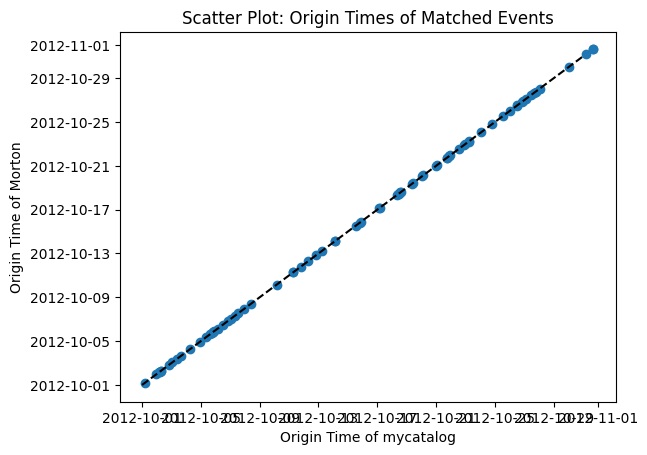

In [15]:
# Make lists for plotting the 1:1 line
x = pd.date_range(start='2012-10-1', end='2012-10-31', periods=len(matched_times_morton))
y = pd.date_range(start='2012-10-1', end='2012-10-31', periods=len(matched_times_morton))

# Plot the scatter plot
plt.figure()
plt.scatter(matched_times_mycatalog,matched_times_morton)
plt.plot(x,y, 'k--')
plt.xlabel('Origin Time of mycatalog')
plt.ylabel('Origin Time of Morton')
plt.title('Scatter Plot: Origin Times of Matched Events')

## Plot the Latitudes from mycatalog and Morton's catalog

Text(0.5, 1.0, 'Scatter Plot: Latitudes of mycatalog vs.Latitudes of Morton')

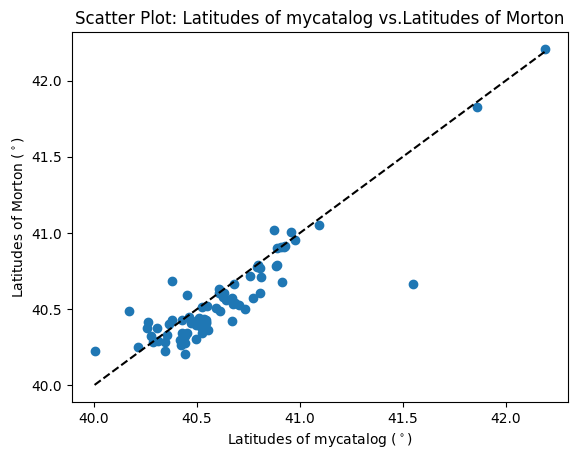

In [16]:
# Plot the scatter plot
plt.figure()
lat_min = min(lat_mycatalog)
lat_max = max(lat_mycatalog)

# Make lists for plotting the 1:1 line
x_lat = np.linspace(lat_min, lat_max, 10)
y_lat = np.linspace(lat_min, lat_max, 10)
plt.scatter(lat_mycatalog,lat_morton)
plt.plot(x_lat,y_lat, 'k--')
plt.xlabel('Latitudes of mycatalog ($^\circ$)')
plt.ylabel('Latitudes of Morton ($^\circ$)')
plt.title('Scatter Plot: Latitudes of mycatalog vs.Latitudes of Morton')

## Plot the longitudes from mycatalog and Morton's catalog

Text(0.5, 1.0, 'Scatter Plot: Longitudes of mycatalog vs.Longitudes of Morton')

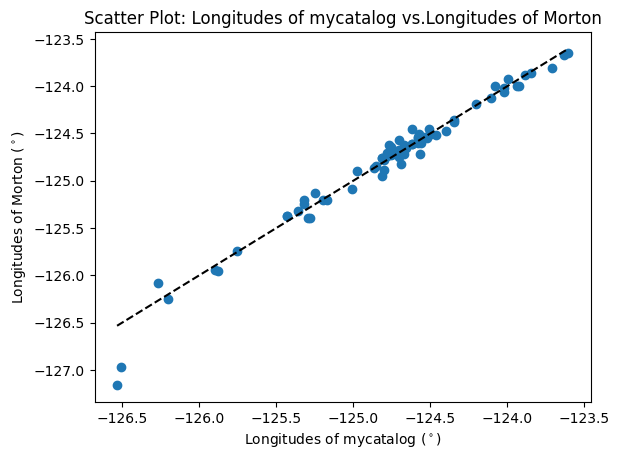

In [17]:
# Plot the scatter plot
plt.figure()
lon_min = min(lon_mycatalog)
lon_max = max(lon_mycatalog)

# Make lists for plotting the 1:1 line
x_lon = np.linspace(lon_min, lon_max, 10)
y_lon = np.linspace(lon_min, lon_max, 10)
plt.scatter(lon_mycatalog,lon_morton)
plt.plot(x_lon,y_lon, 'k--')
plt.xlabel('Longitudes of mycatalog ($^\circ$)')
plt.ylabel('Longitudes of Morton ($^\circ$)')
plt.title('Scatter Plot: Longitudes of mycatalog vs.Longitudes of Morton')

## Histograms
Make histograms of mycatalog vs. Morton's catalog

### Histogram: All of our catalog 

In [24]:
events_october = pd.read_csv('../data/events_october_temp_with_JCC.csv')

In [22]:
len(events_october),len(matched_events_mycatalog),len(unmatched_events_mycatalog)

(414, 78, 91)

In [27]:
events_october

,Unnamed: 0,idx,time,x,y,z,picks,latitude,longitude,depth
0,0,0,2012-10-01 04:32:57.526930+00:00,-95.153374,-109.358894,38.671875,9,40.759805,-125.876866,38.671875
1,1,1,2012-10-01 06:49:31.081854+00:00,-0.583763,-136.034620,37.890625,7,40.525087,-124.756889,37.890625
2,2,2,2012-10-01 07:27:43.749368+00:00,12.259024,-142.894092,40.234375,11,40.463224,-124.605460,40.234375
3,3,3,2012-10-01 11:20:41.930037+00:00,-25.101810,-148.229238,33.984375,9,40.414891,-125.045751,33.984375
4,4,4,2012-10-01 12:32:08.467516+00:00,29.771915,-134.510293,46.484375,19,40.538280,-124.398583,46.484375
...,...,...,...,...,...,...,...,...,...,...
409,409,409,2012-10-31 19:05:30.747144+00:00,-77.640483,-145.942747,24.609375,9,40.432239,-125.664994,24.609375
410,410,410,2012-10-31 19:37:37.707399+00:00,97.488426,-99.450768,25.390625,6,40.848736,-123.593939,25.390625
411,411,411,2012-10-31 22:15:10.233710+00:00,-27.436862,-94.877786,24.609375,10,40.895249,-125.075589,24.609375
412,412,412,2012-10-31 23:36:25.199650+00:00,-107.996161,-132.985966,37.890625,14,40.545507,-126.024869,37.890625


In [32]:
mycatalog[8:30]

,Unnamed: 0,idx,time,x,y,z,picks,latitude,longitude,depth,event_idx,pick_idx,residual,station,phase,time_pick,datetime
8,8,0,2012-10-01 04:32:57.526930+00:00,-95.153374,-109.358894,38.671875,9,40.759805,-125.876866,38.671875,0,122893,-0.169336,M09B,P,1.349066e+09,2012-10-01 04:32:57.526930+00:00
9,9,1,2012-10-01 06:49:31.081854+00:00,-0.583763,-136.034620,37.890625,7,40.525087,-124.756889,37.890625,1,47726,-0.892706,FS20B,P,1.349074e+09,2012-10-01 06:49:31.081854+00:00
10,10,1,2012-10-01 06:49:31.081854+00:00,-0.583763,-136.034620,37.890625,7,40.525087,-124.756889,37.890625,1,191661,0.422576,FS20B,S,1.349074e+09,2012-10-01 06:49:31.081854+00:00
11,11,1,2012-10-01 06:49:31.081854+00:00,-0.583763,-136.034620,37.890625,7,40.525087,-124.756889,37.890625,1,195746,0.234404,G10B,S,1.349074e+09,2012-10-01 06:49:31.081854+00:00
12,12,1,2012-10-01 06:49:31.081854+00:00,-0.583763,-136.034620,37.890625,7,40.525087,-124.756889,37.890625,1,157801,0.313062,JCC,P,1.349074e+09,2012-10-01 06:49:31.081854+00:00
13,13,1,2012-10-01 06:49:31.081854+00:00,-0.583763,-136.034620,37.890625,7,40.525087,-124.756889,37.890625,1,290231,-0.306260,JCC,S,1.349074e+09,2012-10-01 06:49:31.081854+00:00
14,14,1,2012-10-01 06:49:31.081854+00:00,-0.583763,-136.034620,37.890625,7,40.525087,-124.756889,37.890625,1,155494,0.452564,KMPB,P,1.349074e+09,2012-10-01 06:49:31.081854+00:00
15,15,1,2012-10-01 06:49:31.081854+00:00,-0.583763,-136.034620,37.890625,7,40.525087,-124.756889,37.890625,1,287961,-0.223639,KMPB,S,1.349074e+09,2012-10-01 06:49:31.081854+00:00
16,16,2,2012-10-01 07:27:43.749368+00:00,12.259024,-142.894092,40.234375,11,40.463224,-124.605460,40.234375,2,4867,1.310642,FS13B,P,1.349076e+09,2012-10-01 07:27:43.749368+00:00
17,17,2,2012-10-01 07:27:43.749368+00:00,12.259024,-142.894092,40.234375,11,40.463224,-124.605460,40.234375,2,161681,-0.286512,FS13B,S,1.349076e+09,2012-10-01 07:27:43.749368+00:00


In [20]:
# Plot the histogram of the number of picks for all events in events_october.csv
# plt.figure()
# fig,ax = plt.subplots(2,sharex=True)
# bins = np.linspace(5,26,20)
# ax[0].hist(events_october['picks'], bins=bins)

# # ax[0].set_xlabel('Number of Picks')
# ax[0].set_ylabel('Number of Events')
# ax[0].set_title('Histogram of Picks vs. the Number of Events')

# ax[1].hist(matched_events_mycatalog['picks'],bins=bins)
# ax[1].set_xlabel('Number of Picks')
# ax[1].set_ylabel('Number of Events')
# ax[1].set_title('Histogram of Matched Events: Picks vs. the Number of Events')

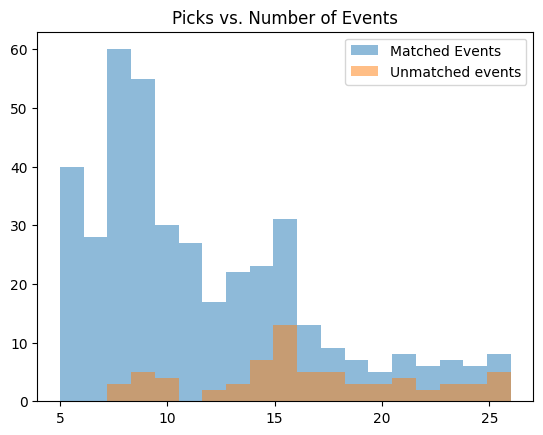

In [23]:
# Plot the same histogram but overlay the histograms
bins = np.linspace(5,26,20)

plt.hist(events_october['picks'], bins=bins,  
         alpha=0.5, # the transaparency parameter 
         label='Matched Events') 
  
plt.hist(matched_events_mycatalog['picks'], bins=bins,
         alpha=0.5, 
         label='Unmatched events') 
  
plt.legend(loc='upper right') 
plt.title('Picks vs. Number of Events') 
plt.show()


### Histogram: Those matched with Morton (73 events)

Text(0.5, 1.0, 'Histogram of Matched Events: Picks vs. the Number of Events')

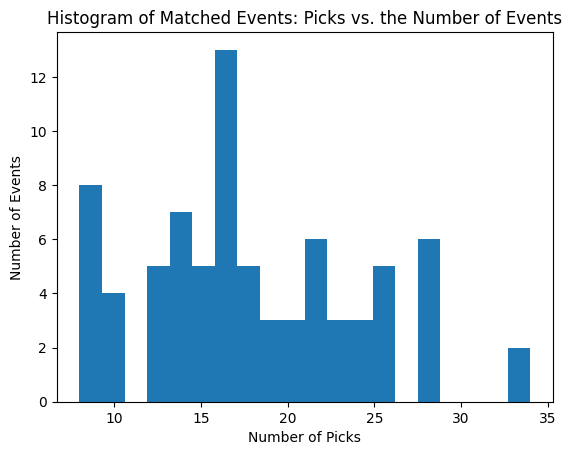

In [25]:
# Plot the histogram of the number of picks for the matched events
plt.figure()
plt.hist(matched_events_mycatalog['picks'],bins=20)
plt.xlabel('Number of Picks')
plt.ylabel('Number of Events')
plt.title('Histogram of Matched Events: Picks vs. the Number of Events')

### Plot the waveforms of one of the matched events 

In [ ]:
client = WaveformClient()
client2 = Client("IRIS")

In [ ]:
# Get the list of stations
station_list = ['FS09B',
 'FS13B',
 'FS16B',
 'FS17B',
 'FS20B',
 'G10B',
 'G17B',
 'G19B',
 'G25B',
 'G26B',
 'G27B',
 'J09B',
 'J25B',
 'J33B',
 'M09B',
 'M12B',
 'M14B']

In [ ]:
mycatalog[mycatalog['idx'] == 9]

In [ ]:
mycatalog['station'].unique()

In [ ]:
distances

In [ ]:
distances.keys()

In [ ]:
idx = 0
otime = UTCDateTime(mycatalog['datetime'].unique()[idx])
distances = {}
for i, sta in enumerate(station_list):
    sta_inv = client2.get_stations(network = "7D", station = sta, channel = "?H?", 
                     starttime = otime - 1e4, endtime = otime + 1e4)[0][0]
    slat = sta_inv.latitude
    slon = sta_inv.longitude
    olat = mycatalog['latitude'].unique()[idx]
    olon = mycatalog['longitude'].unique()[idx]

    dis1 = locations2degrees(olat, olon, slat, slon)
    dist = degrees2kilometers(dis1)
    distances[sta] = dist
distances = {k: v for k, v in sorted(distances.items(), key=lambda item: item[1])}
# print(distances.keys())
print(otime)
plt.figure(figsize=(15,10), dpi=150)
for i, sta in enumerate(distances.keys()):
    st = client.get_waveforms(network="7D", station=sta, channel="?H?", year=2012, month=10, day=14)
    st = obspy.Stream(filter(lambda st:st.stats.sampling_rate>10, st))
    st.filter(type='bandpass',freqmin=4,freqmax=15)

    trim_st = st.copy().trim(starttime = otime - 30, 
                endtime = otime + 60)
    if len(trim_st)>0:
        trim_st = trim_st.normalize()
        offsets1  = np.arange(0,len(trim_st))
        offsets2 = np.arange(0,len(station_list)* (len(trim_st)),len(trim_st))

        for ii in range(len(trim_st)):
            plt.plot(trim_st[ii].times(type='utcdatetime'), trim_st[ii].data+offsets1[ii]*0.5+offsets2[i], 
                     color = 'gray', alpha=0.7, lw=0.5)    
        time_pick = [[x['time_pick'], x['phase']] for _, x in mycatalog[mycatalog['idx'] == idx].iterrows() 
                     if x['station'] == sta]
        if len(time_pick) > 0:
            for p in time_pick:
                if p[1] == 'P':
                    plt.vlines(p[0], offsets1[ii]*0.5+offsets2[i]-1, 
                                     offsets1[ii]*0.5+offsets2[i]+1, color='r')
                else:
                    plt.vlines(p[0], offsets1[ii]*0.5+offsets2[i]-1, 
                                     offsets1[ii]*0.5+offsets2[i]+1, color='b')
    else:                 
        pass 
plt.show()

In [ ]:
st = client.get_waveforms(network="7D", station='FS16B', channel="?H?", year=2012, month=10, day=14)
st = obspy.Stream(filter(lambda st:st.stats.sampling_rate>10, st))
st.filter(type='bandpass',freqmin=4,freqmax=15)

trim_st = st.copy().trim(starttime = otime - 30, 
            endtime = otime + 60)
trim_st
st

In [ ]:
otime